In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
import string
import plotly.express as px
import csv
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import plotly.express as px


In [2]:
torch.cuda.is_available()
torch.__version__

'1.13.0'

In [3]:
def parse_text_file(content, filename):
    return {
        'Source' : filename,
        'Content': content
    }

def read_and_parse_files(directory):
    """
    Read all text files in the specified directory and parse their content.
    This function includes a fallback for different file encodings.
    """
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            try:
                # Trying to read with UTF-8 encoding
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
            except UnicodeDecodeError:
                # Fallback to ISO-8859-1 encoding if UTF-8 fails
                with open(file_path, 'r', encoding='iso-8859-1') as file:
                    content = file.read()

            parsed_data = parse_text_file(content, filename)
            data.append(parsed_data)
    return data

def write_to_csv(data, csv_file_path):
    """
    Write the parsed data to a CSV file.
    """
    headers = ['Source', 'Content']
    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        writer.writeheader()
        for row in data:
            writer.writerow(row)

# NGO
parsed_data_NGO_COP15 = read_and_parse_files('climate-discourses/NGO/ONG_COP15/')
write_to_csv(parsed_data_NGO_COP15, 'combined-data/combined_articles-NGO_COP15.csv')

parsed_data_NGO_COP21 = read_and_parse_files('climate-discourses/NGO/ONG_COP21/')
write_to_csv(parsed_data_NGO_COP21, 'combined-data/combined_articles-NGO_COP21.csv')

parsed_data_NGO_COP25_26 = read_and_parse_files('climate-discourses/NGO/ONG_COP25_26/')
write_to_csv(parsed_data_NGO_COP25_26, 'combined-data/combined_articles-NGO_COP25_26.csv')

# IGO
parsed_data_IGO_COP15 = read_and_parse_files('climate-discourses/IGO/OIG_COP15/')
write_to_csv(parsed_data_IGO_COP15, 'combined-data/combined_articles-IGO_COP15.csv')

parsed_data_IGO_COP21 = read_and_parse_files('climate-discourses/IGO/OIG_COP21/')
write_to_csv(parsed_data_IGO_COP21, 'combined-data/combined_articles-IGO_COP21.csv')

parsed_data_IGO_COP25_26 = read_and_parse_files('climate-discourses/IGO/OIG_COP25_26/')
write_to_csv(parsed_data_IGO_COP25_26, 'combined-data/combined_articles-IGO_COP25_26.csv')


# News
parsed_data_news_COP15 = read_and_parse_files('climate-discourses/news/Presse_COP15/')
write_to_csv(parsed_data_news_COP15, 'combined-data/combined_articles-news_COP15.csv')

parsed_data_news_COP21 = read_and_parse_files('climate-discourses/news/Presse_COP21/')
write_to_csv(parsed_data_news_COP21, 'combined-data/combined_articles-news_COP21.csv')

parsed_data_news_COP25_26 = read_and_parse_files('climate-discourses/news/Presse_COP25_26/')
write_to_csv(parsed_data_news_COP25_26, 'combined-data/combined_articles-news_COP25_26.csv')



In [4]:
# Merge IGO's with eachother in one csv file
IGO_COP15 = pd.read_csv('combined-data/combined_articles-IGO_COP15.csv')
IGO_COP21 = pd.read_csv('combined-data/combined_articles-IGO_COP21.csv')
IGO_COP25_26 = pd.read_csv('combined-data/combined_articles-IGO_COP25_26.csv')

IGO_COP15_COP21 = pd.concat([IGO_COP15, IGO_COP21])

IGO_COP15_COP21.to_csv('combined-data/general-IGO.csv', index=False)

# Merge NGO's with eachother in one csv file
NGO_COP15 = pd.read_csv('combined-data/combined_articles-NGO_COP15.csv')
NGO_COP21 = pd.read_csv('combined-data/combined_articles-NGO_COP21.csv')
NGO_COP25_26 = pd.read_csv('combined-data/combined_articles-NGO_COP25_26.csv')

NGO_COP15_COP21 = pd.concat([NGO_COP15, NGO_COP21])

NGO_COP15_COP21.to_csv('combined-data/general-NGO.csv', index=False)

# Merge news with eachother in one csv file
news_COP15 = pd.read_csv('combined-data/combined_articles-news_COP15.csv')
news_COP21 = pd.read_csv('combined-data/combined_articles-news_COP21.csv')
news_COP25_26 = pd.read_csv('combined-data/combined_articles-news_COP25_26.csv')

news_COP15_COP21 = pd.concat([news_COP15, news_COP21])

news_COP15_COP21.to_csv('combined-data/general-news.csv', index=False)

In [5]:
lines = True

if lines:
    df_news = pd.read_csv('combined-data/general-news-lines.csv')
    df_IGO = pd.read_csv('combined-data/general-IGO-lines.csv')
    df_NGO = pd.read_csv('combined-data/general-NGO-lines.csv')
else:
    df_news = pd.read_csv('combined-data/general-news.csv')
    df_IGO = pd.read_csv('combined-data/general-IGO.csv')
    df_NGO = pd.read_csv('combined-data/general-NGO.csv')



In [6]:
def getLines(df_input):
    # create entries for each line in the content row in a new dataframe
    df = pd.DataFrame(df_input.Content.str.split('.').tolist(), index=df_input.Source).stack()

    # remove empyt lines
    df = df[df != '']

    # remove lines with only one character
    df = df[df.str.len() > 1]

    # remove lines with only one word
    df = df[df.str.split().str.len() > 1]
    # reset index
    df = df.reset_index([0, 'Source'])

    # rename columns
    df.columns = ['Source', 'Content']
    return df

In [7]:
def cleanData(df, stopwordList= []):
        # convert 'Content' to 'Snippet'
    df.rename(columns={'Content': 'Snippet'}, inplace=True)

    # Remove rows with NaN in 'Snippet' column
    df = df.dropna(subset=['Snippet'])

    # Convert 'Snippet' column to strings in case there are any non-string types (wordnet breaks otherwise)
    df['Snippet'] = df['Snippet'].astype(str)

    # Lowercase all words
    df['Snippet'] = df['Snippet'].str.lower()

    # Remove punctuation
    df['Snippet'] = df['Snippet'].str.replace('[{}]'.format(string.punctuation), '')

    # Remove special characters
    df['Snippet'] = df['Snippet'].str.replace('[^A-Za-z ]+', '')

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    # Add excluded words to stopwords
    stop_words.update(['said', 'would', 'also', 'could', 'year', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'])
    # Add custom stopwords
    stop_words.update(stopwordList)

    df['Snippet'] = df['Snippet'].apply(lambda x: ' '.join([item for item in x.split() if item.lower() not in stop_words]))

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    df['Snippet'] = df['Snippet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(item) for item in x.split()]))
    
    return df

In [8]:
def generateWordcloud(df, stopwordList = [], ngram_1 = 2, ngram_2 = 5):
    # create wordcloud
    wordcloudNews = WordCloud(width=1000, height=800, background_color="white", colormap='viridis').generate(' '.join(df['Snippet'].astype(str)))

    # count most frequent words
    words = word_tokenize(' '.join(df['Snippet'].astype(str)))
    fdist = FreqDist(words)
    #order by frequency
    fdist = {k: v for k, v in sorted(fdist.items(), key=lambda item: item[1], reverse=True)}

    # Tokenize the 'Snippet' column into words
    df['Tokens'] = df['Snippet'].apply(word_tokenize)

    # Create n-grams
    df['ngram_1'] = df['Tokens'].apply(lambda x: [' '.join(ngram) for ngram in nltk.ngrams(x, ngram_1) if len(ngram) == ngram_1])
    df['ngram_2'] = df['Tokens'].apply(lambda x: [' '.join(ngram) for ngram in nltk.ngrams(x, ngram_2) if len(ngram) == ngram_2])

    # Flatten the list of n-grams
    all_ngrams_1 = [ngram for snippet in df['ngram_1'] for ngram in snippet]
    all_ngrams_2 = [ngram for snippet in df['ngram_2'] for ngram in snippet]

    # Calculate frequency distribution
    ngram_freq_1 = FreqDist(all_ngrams_1)
    ngram_freq_2 = FreqDist(all_ngrams_2)

    # Get top 20 n-grams
    top_ngrams_1 = ngram_freq_1.most_common(20)
    top_ngrams_2 = ngram_freq_2.most_common(20)

    #  Download the vader_lexicon, which contains the rules for the Vader SentimentAnalyzer. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.
    nltk.download('vader_lexicon')

    # Initialize the VADER sentiment intensity analyzer
    sid = SentimentIntensityAnalyzer()

    # Assume df is your DataFrame and 'text_column' is the column with the text
    df['sentiment'] = df['Snippet'].apply(lambda text: sid.polarity_scores(text))

    # Convert the sentiment scores dictionary into columns
    df = pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)

    # Setting up the subplot grid
    fig = plt.figure(figsize=(20, 30))

    # Wordcloud
    ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=1)
    ax1.imshow(wordcloudNews, interpolation='bilinear')
    ax1.axis("off")

    # Most frequent words
    ax2 = plt.subplot2grid((4, 2), (0, 1), colspan=1)
    freq_words_df = pd.DataFrame({'Word': list(fdist.keys())[:20], 'Frequency': list(fdist.values())[:20]})
    sns.barplot(x='Frequency', y='Word', data=freq_words_df, ax=ax2)
    ax2.set_title('Most frequent words')
    ax2.grid(axis='x')

    # Most frequent 2-grams
    ax3 = plt.subplot2grid((4, 2), (1, 0), colspan=2)  # Spans entire width of row 2
    top_ngrams_1_df = pd.DataFrame({'2-gram': [ngram[0] for ngram in top_ngrams_1], 'Frequency': [ngram[1] for ngram in top_ngrams_1]})
    sns.barplot(x='Frequency', y='2-gram', data=top_ngrams_1_df, ax=ax3)
    ax3.set_title('Most frequent 2-grams')
    ax3.grid(axis='x')

    # Most frequent 5-grams
    ax4 = plt.subplot2grid((4, 2), (2, 0), colspan=2)  # Spans entire width of row 3
    top_ngrams_2_df = pd.DataFrame({'5-gram': [ngram[0] for ngram in top_ngrams_2], 'Frequency': [ngram[1] for ngram in top_ngrams_2]})
    sns.barplot(x='Frequency', y='5-gram', data=top_ngrams_2_df, ax=ax4)
    ax4.set_title('Most frequent 5-grams')
    ax4.grid(axis='x')

    # Sentiment
    ax5 = plt.subplot2grid((4, 2), (3, 0), colspan=1)
    sns.histplot(df['compound'], bins=20, color='skyblue', kde=False)
    ax5.set_title('Sentiment Analysis')
    ax5.set_xlabel('Compound Score')
    ax5.set_ylabel('Frequency')

    # Sentiment piechart
    ax6 = plt.subplot2grid((4, 2), (3, 1), colspan=1)
    labels = ['Positive', 'Negative', 'Neutral']
    sizes = [len(df[df['compound'] > 0.5]), len(df[df['compound'] < -0.5]), len(df[(df['compound'] >= -0.5) & (df['compound'] <= 0.5)])]
    colors = ['green', 'red', 'grey']
    explode = (0, 0, 0)
    plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.legend(labels, loc="best")
    plt.axis('equal')


    plt.tight_layout()
    plt.show()

In [9]:
sentiment_labels = {
    0: 'admiration',
    1: 'amusement',
    2: 'anger',
    3: 'annoyance',
    4: 'approval',
    5: 'caring',
    6: 'confusion',
    7: 'curiosity',
    8: 'desire',
    9: 'disappointment',
    10: 'disapproval',
    11: 'disgust',
    12: 'embarrassment',
    13: 'excitement',
    14: 'fear',
    15: 'gratitude',
    16: 'grief',
    17: 'joy',
    18: 'love',
    19: 'nervousness',
    20: 'optimism',
    21: 'pride',
    22: 'realization',
    23: 'relief',
    24: 'remorse',
    25: 'sadness',
    26: 'surprise',
    27: 'neutral',
}


def getSentimentLabel(df, name):
    sentiment_percentages = df['Sentiment'].value_counts(normalize=True) * 100
    sentiment_percentages = sentiment_percentages.round(2)
    sentiment_percentages.index = sentiment_percentages.index.map(sentiment_labels)
    # do not use neutral sentiment
    sentiment_percentages = sentiment_percentages[1:27]
    fig = px.treemap(
        names=sentiment_percentages.index,
        parents=[''] * len(sentiment_percentages),  # All at the root level
        values=sentiment_percentages.values,
        title='Sentiment Distribution '+ name +' (in percentages)'
    )
    fig.update_layout(width=500, height=500)
    fig.show()

In [10]:
df_news_lines = getLines(df_news)
df_NGO_lines = getLines(df_NGO)
df_IGO_lines = getLines(df_IGO)

# save to csv
df_news_lines.to_csv('combined-data/general-news-lines.csv')
df_NGO_lines.to_csv('combined-data/general-NGO-lines.csv')
df_IGO_lines.to_csv('combined-data/general-IGO-lines.csv')

In [11]:
df_news = cleanData(df_news)
df_NGO = cleanData(df_NGO)
df_IGO = cleanData(df_IGO)

C:\Users\jules\AppData\Local\Temp\ipykernel_5468\3177574849.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Snippet'] = df['Snippet'].str.replace('[{}]'.format(string.punctuation), '')
C:\Users\jules\AppData\Local\Temp\ipykernel_5468\3177574849.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Snippet'] = df['Snippet'].str.replace('[^A-Za-z ]+', '')
C:\Users\jules\AppData\Local\Temp\ipykernel_5468\3177574849.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Snippet'] = df['Snippet'].str.replace('[{}]'.format(string.punctuation), '')
C:\Users\jules\AppData\Local\Temp\ipykernel_5468\3177574849.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Snippet'] = df['Snippet'].str.replace('[^A-Za-z ]+', '')
C:\Users\jules\AppData\Local\Temp\ipykernel_5468\3177574849.py:1

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jules\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


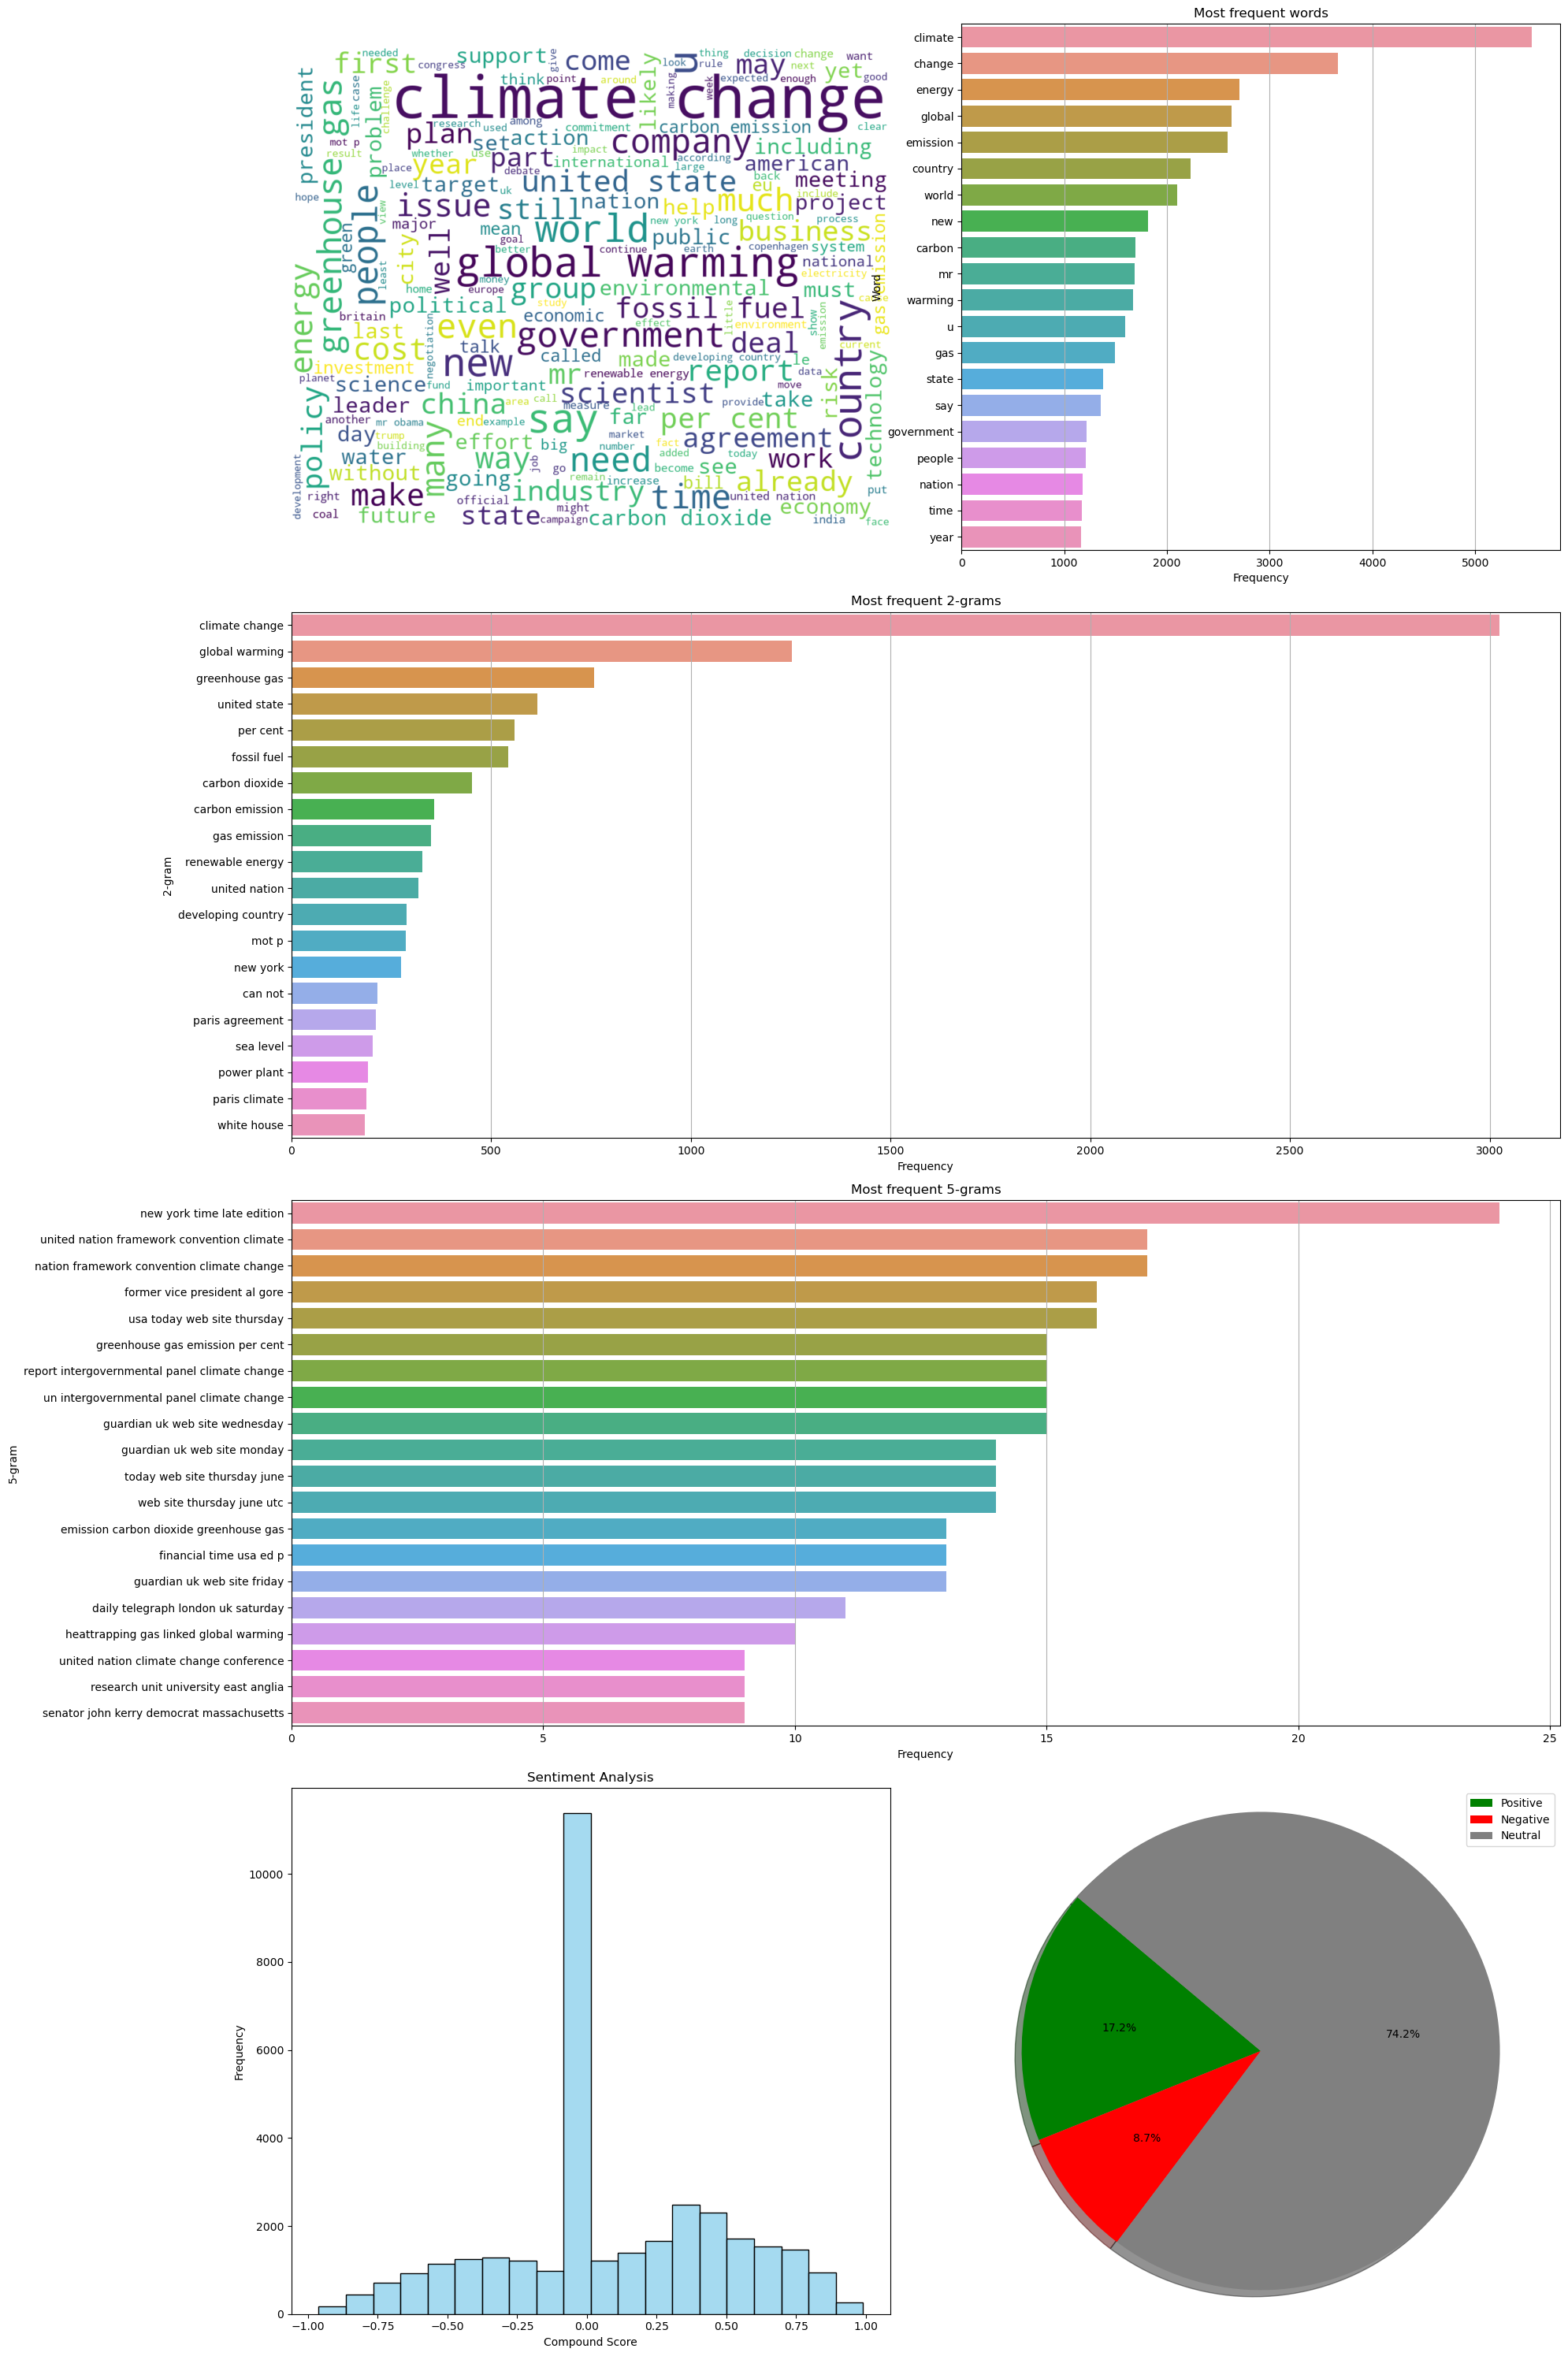

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jules\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


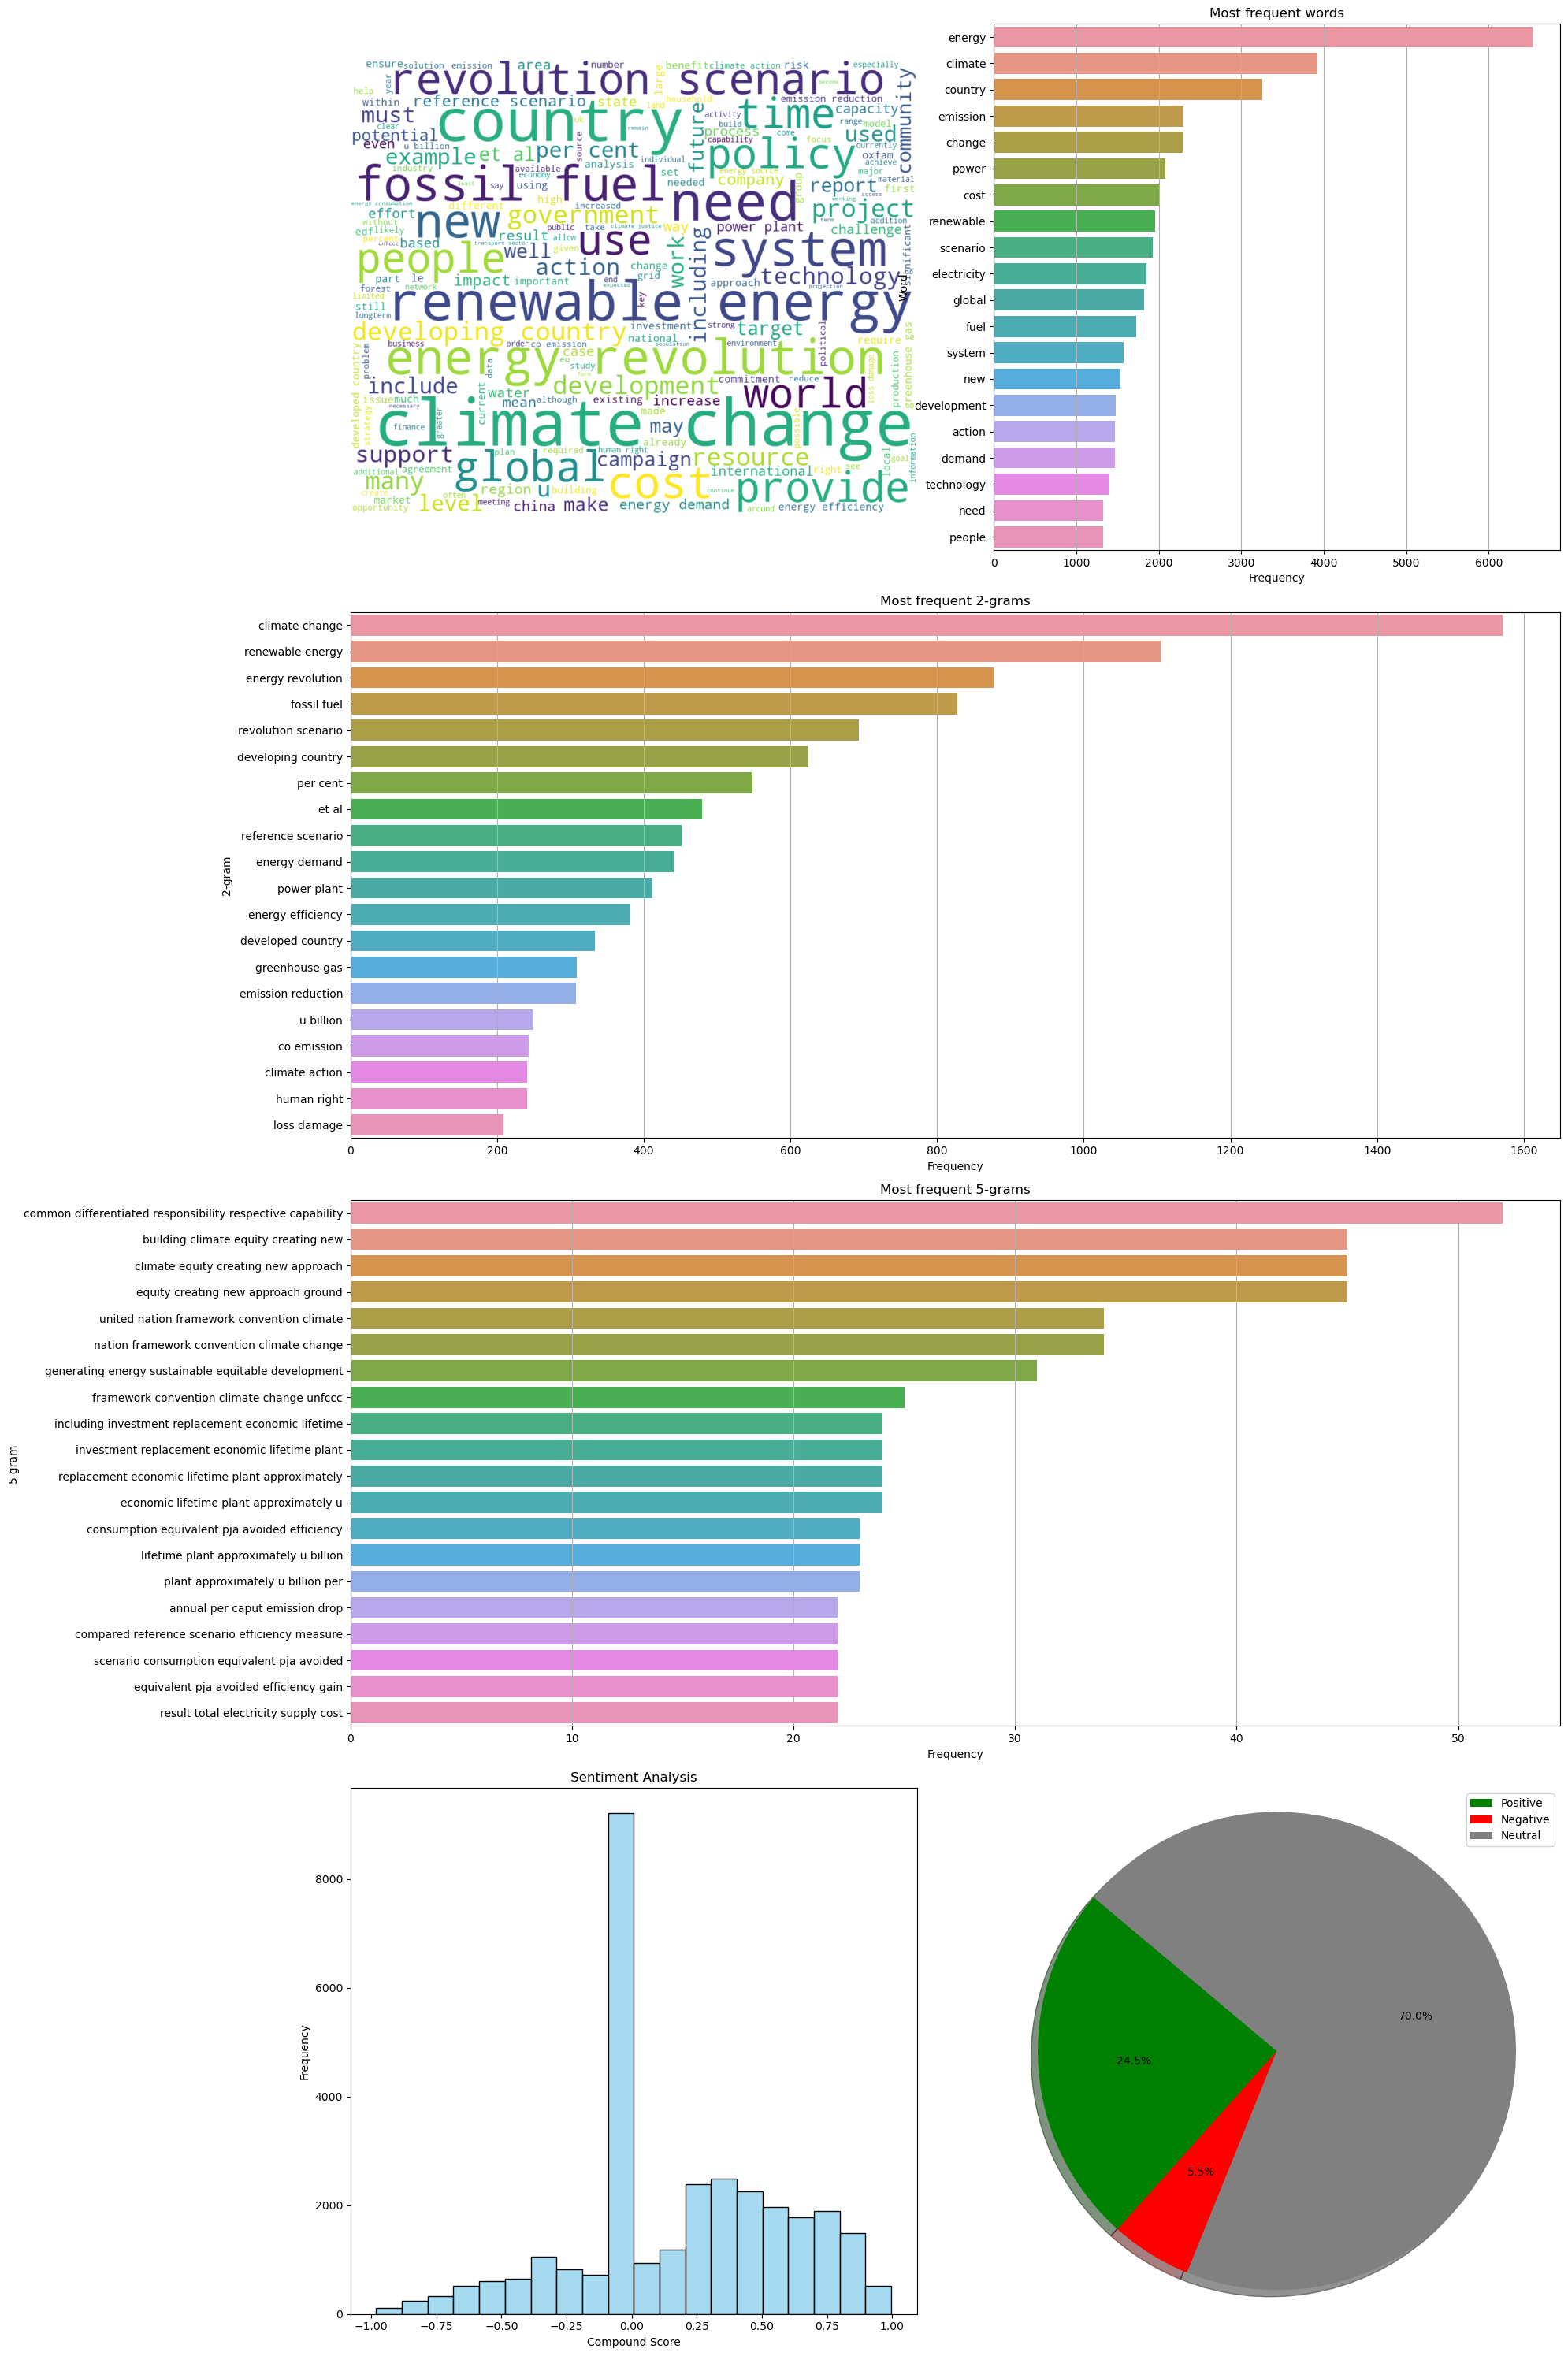

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jules\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


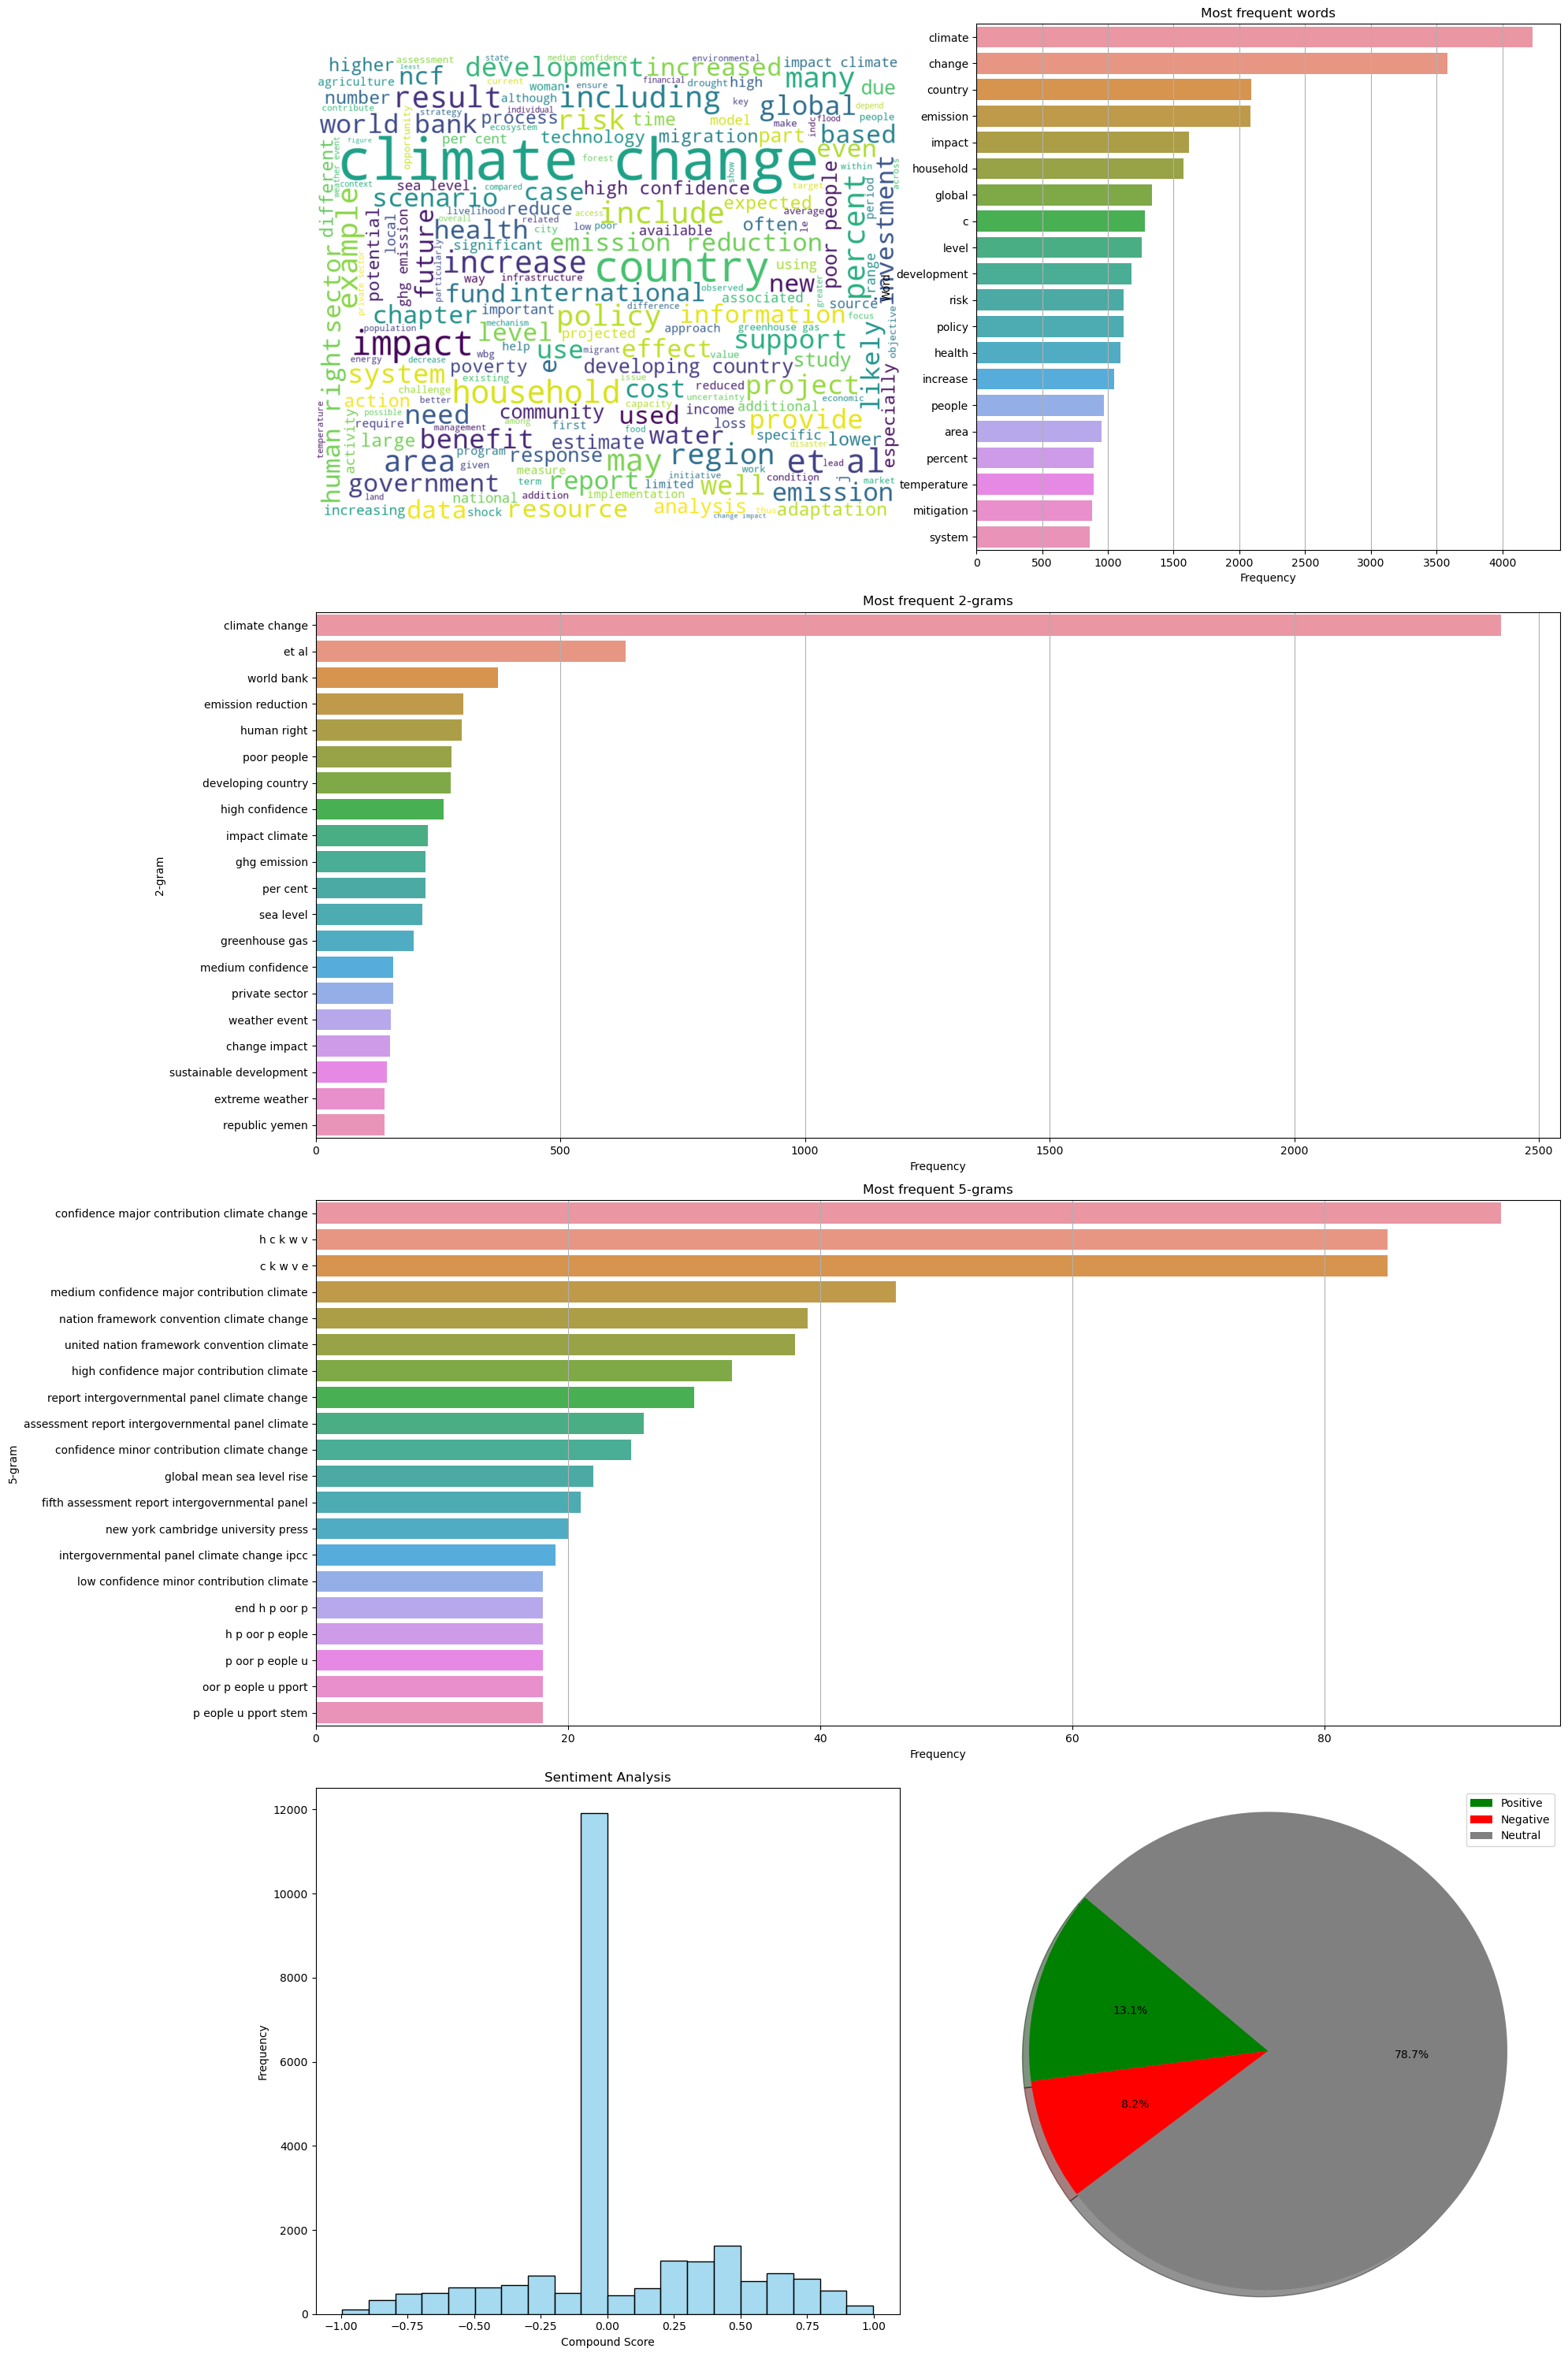

In [12]:
generateWordcloud(df_news)
generateWordcloud(df_NGO)
generateWordcloud(df_IGO)

In [13]:
# Ensure CUDA (GPU support) is available and enabled.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the tokenizer and model.
model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

# Model evaluation mode, dropout layers are disabled. Used when making predictions and using the pretrained model.
# Pytorch assumes the model is in training mode by default.
model.eval()

def classify_emotion(snippet):
    # Tokenize the batch of snippets.
    inputs = tokenizer(snippet, return_tensors="pt", padding=True, truncation=True).to(device)
    
    # Make predictions.
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted class index.
    predictions = torch.argmax(outputs.logits, dim=-1)
    return predictions.cpu().numpy()

def getSentiment(df, batch_size = 16):
    # Process the snippets in batches.
    batch_size = batch_size 
    sentiments = []

    for i in tqdm(range(0, len(df['Snippet']), batch_size), desc="Classifying"):
        batch_snippets = df['Snippet'][i:i + batch_size].tolist()
        batch_predictions = classify_emotion(batch_snippets)
        sentiments.extend(batch_predictions)

    # Assign the predictions to the DataFrame.
    df['Sentiment'] = sentiments

    return df

# Clean the data
df_news = cleanData(df_news)
df_NGO = cleanData(df_NGO)
df_IGO = cleanData(df_IGO)

# Get the sentiment
df_news = getSentiment(df_news)
df_NGO = getSentiment(df_NGO)
df_IGO = getSentiment(df_IGO)

C:\Users\jules\AppData\Local\Temp\ipykernel_5468\3177574849.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Snippet'] = df['Snippet'].str.replace('[{}]'.format(string.punctuation), '')
C:\Users\jules\AppData\Local\Temp\ipykernel_5468\3177574849.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Snippet'] = df['Snippet'].str.replace('[^A-Za-z ]+', '')
C:\Users\jules\AppData\Local\Temp\ipykernel_5468\3177574849.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Snippet'] = df['Snippet'].str.replace('[{}]'.format(string.punctuation), '')
C:\Users\jules\AppData\Local\Temp\ipykernel_5468\3177574849.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Snippet'] = df['Snippet'].str.replace('[^A-Za-z ]+', '')
C:\Users\jules\AppData\Local\Temp\ipykernel_5468\3177574849.py:1

Classifying:   0%|          | 0/2155 [00:00<?, ?it/s]

Classifying:   0%|          | 0/1947 [00:00<?, ?it/s]

Classifying:   0%|          | 0/1579 [00:00<?, ?it/s]

In [14]:
getSentimentLabel(df_news, 'News')
getSentimentLabel(df_NGO, 'NGO')
getSentimentLabel(df_IGO, 'IGO')

In [15]:
def createTSNE(df):
    df['Tokenized_Snippet'] = df['Snippet'].apply(lambda x: word_tokenize(x))
    model = Word2Vec(df['Tokenized_Snippet'], vector_size=100, window=5, min_count=10, sg=0)
    # Parameters:
    # - vector_size: Number of dimensions for word vectors.
    # - window: Maximum distance between the current and predicted word within a sentence.
    # - min_count: Ignores all words with a total frequency lower than this.
    # - sg: Training algorithm. sg=0 for CBOW, sg=1 for Skip-gram.
    word_vectors = model.wv

    # Select a subset of words you want to visualize (e.g., top 100 words)
    words_to_visualize = list(word_vectors.index_to_key[:200])

    # Get the word vectors for the selected words and convert to a NumPy array
    vectors = np.array([word_vectors[word] for word in words_to_visualize])

    tsne3D = TSNE(n_components=3, random_state=42)
    word_vectors_3D = tsne3D.fit_transform(vectors)

    df_tsne_3d = pd.DataFrame(data=word_vectors_3D, columns=['Dimension1', 'Dimension2', 'Dimension3'])

    fig_3d = px.scatter_3d(df_tsne_3d, x='Dimension1', y='Dimension2', z='Dimension3', text=words_to_visualize)
    fig_3d.update_layout(width=1000, height=1000, scene=dict(bgcolor='black'))
    fig_3d.update_traces(marker=dict(size=3, color='green'), textfont_color='grey') 
    fig_3d.update_layout(scene=dict(
        xaxis=dict(showbackground=True, backgroundcolor='black', showgrid=False), 
        yaxis=dict(showbackground=True, backgroundcolor='black', showgrid=False),
        zaxis=dict(showbackground=True, backgroundcolor='black', showgrid=False), 
    ))
    fig_3d.show()

createTSNE(df_news)
createTSNE(df_NGO)
createTSNE(df_IGO)